## Importing Data

In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# --- IMPORTANT: Download the JSON file first ---

file_path = 'user-wallet-transactions.json' # Make sure this path is correct

# Load the JSON data

try:
    # If the JSON is a list of objects at the top level
    df = pd.read_json(file_path)
    print("Successfully loaded JSON into DataFrame.")
    print(f"DataFrame shape: {df.shape}")
    print(df.head())
except ValueError as e:
    print(f"Error loading JSON directly: {e}")
    print("Trying to load line by line (if it's JSONL format or corrupted).")
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        print("Successfully loaded JSON from file object into DataFrame.")
        print(f"DataFrame shape: {df.shape}")
        print(df.head())
    except Exception as e_inner:
        print(f"Failed to load JSON even with fallback: {e_inner}")

Successfully loaded JSON into DataFrame.
DataFrame shape: (100000, 13)
                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d04

## Data Cleaning and Processing

In [4]:
# Function to safely convert large string integers to float (assuming standard units)
def convert_amount_to_numeric(amount_str, asset_symbol):
    try:
        if asset_symbol in ['USDC', 'USDT']:
            return float(amount_str) / 10**6 # Assuming 6 decimals
        elif asset_symbol in ['WETH', 'WMATIC', 'DAI', 'WBTC']: # Most common are 18, BTC is 8
            return float(amount_str) / 10**18 # Assuming 18 decimals for others (adjust for WBTC-8)
        else:
            return float(amount_str) # Default, might be incorrect
    except (ValueError, TypeError):
        return np.nan # Handle cases where conversion fails

# Apply the conversion
df['numeric_amount'] = df.apply(lambda row: convert_amount_to_numeric(row['actionData']['amount'], row['actionData']['assetSymbol']), axis=1)

df['numeric_assetPriceUSD'] = pd.to_numeric(df['actionData'].apply(lambda x: x['assetPriceUSD']), errors='coerce')

# Calculate USD value of each transaction
df['usd_value'] = df['numeric_amount'] * df['numeric_assetPriceUSD']

# Convert timestamps
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s') # 'unit=s' for Unix timestamp in seconds
df['createdAt_dt'] = pd.to_datetime(df['createdAt'].apply(lambda x: x['$date']))
df['updatedAt_dt'] = pd.to_datetime(df['updatedAt'].apply(lambda x: x['$date']))


print("\nAfter initial cleaning:")
print(df[['userWallet', 'action', 'actionData', 'numeric_amount', 'numeric_assetPriceUSD', 'usd_value', 'timestamp_dt']].head())
print(df.info())


After initial cleaning:
                                   userWallet            action  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit   
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit   
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit   
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit   
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying   

                                          actionData  numeric_amount  \
0  {'type': 'Deposit', 'amount': '2000000000', 'a...     2000.000000   
1  {'type': 'Deposit', 'amount': '145000000000000...      145.000000   
2  {'type': 'Deposit', 'amount': '100000000000000...        0.001000   
3  {'type': 'Deposit', 'amount': '400000000000000...        0.004000   
4  {'type': 'RedeemUnderlying', 'amount': '501548...        0.501548   

   numeric_assetPriceUSD    usd_value        timestamp_dt  
0               0.993832  1987.663655 2021-08-17 05:29:26  
1               1.9

## Feature Engineering

In [5]:
# Group by userWallet to create wallet-level features

# Example features (you will need to add many more based on the ideas discussed previously)
wallet_features = df.groupby('userWallet').agg(
    total_transactions=('txHash', 'nunique'), # Number of unique transactions
    first_transaction_date=('timestamp_dt', 'min'),
    last_transaction_date=('timestamp_dt', 'max'),
    # Aggregate USD values based on action type
    total_deposit_usd=('usd_value', lambda x: x[df['action'] == 'deposit'].sum()),
    total_borrow_usd=('usd_value', lambda x: x[df['action'] == 'borrow'].sum()),
    total_repay_usd=('usd_value', lambda x: x[df['action'] == 'repay'].sum()),
    num_liquidations=('action', lambda x: (x == 'liquidationcall').sum())
).reset_index()

# Calculate derived features after initial aggregation
wallet_features['account_age_days'] = (wallet_features['last_transaction_date'] - wallet_features['first_transaction_date']).dt.days

# Handle potential division by zero for ratios
wallet_features['borrow_to_deposit_ratio'] = wallet_features.apply(
    lambda row: row['total_borrow_usd'] / row['total_deposit_usd'] if row['total_deposit_usd'] > 0 else 0,
    axis=1
)

wallet_features['repayment_ratio'] = wallet_features.apply(
    lambda row: row['total_repay_usd'] / row['total_borrow_usd'] if row['total_borrow_usd'] > 0 else 0,
    axis=1
)

# Cap repayment ratio at 1.0 or higher if over-repaid
wallet_features['repayment_ratio'] = wallet_features['repayment_ratio'].clip(upper=1.0) # Cap at 1 for simplicity, or 1.1 if over-repaying is positive

print("\nEngineered Wallet Features:")
print(wallet_features.head())
print(wallet_features.info())


Engineered Wallet Features:
                                   userWallet  total_transactions  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6                   1   
1  0x000000000051d07a4fb3bd10121a343d85818da6                   1   
2  0x000000000096026fb41fc39f9875d164bd82e2dc                   2   
3  0x0000000000e189dd664b9ab08a33c4839953852c                  14   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee                 399   

  first_transaction_date last_transaction_date  total_deposit_usd  \
0    2021-08-17 05:29:26   2021-08-17 05:29:26       1.987664e+03   
1    2021-05-20 15:36:53   2021-05-20 15:36:53       2.856945e+02   
2    2021-07-24 09:28:33   2021-07-31 23:15:18       5.152311e-03   
3    2021-04-19 15:23:17   2021-08-26 23:15:16       0.000000e+00   
4    2021-04-21 21:28:30   2021-09-01 18:15:24       1.514858e+22   

   total_borrow_usd  total_repay_usd  num_liquidations  account_age_days  \
0      0.000000e+00         0.000000                 0           

## Modeling

In [7]:
# --- Credit Score Logic (Rule-Based Example) ---

def calculate_credit_score(row):
    score = 500 # Starting base score

    # Positive contributions
    score += min(row['total_deposit_usd'] / 1000, 200) # Max 200 points for deposits (e.g., 1000 USD = 1 point)
    score += min(row['total_repay_usd'] / 500, 150) # Max 150 points for repayments
    score += min(row['account_age_days'] / 10, 100) # Max 100 points for age
    score += min(row['total_transactions'] / 10, 50) # Max 50 points for activity

    # Negative contributions
    if row['num_liquidations'] > 0:
        score -= min(row['num_liquidations'] * 100, 400) # Penalize liquidations heavily
    if row['repayment_ratio'] < 0.7: # Penalize low repayment ratio
        score -= (0.7 - row['repayment_ratio']) * 200

    # Penalize high borrow-to-deposit ratio if not well repaid
    if row['borrow_to_deposit_ratio'] > 0.8 and row['repayment_ratio'] < 0.9:
        score -= min((row['borrow_to_deposit_ratio'] - 0.8) * 100, 100)

    # Ensure score is within 0-1000
    return max(0, min(1000, score))

wallet_features['credit_score'] = wallet_features.apply(calculate_credit_score, axis=1)

print("\nWallets with Credit Scores:")
print(wallet_features[['userWallet', 'total_deposit_usd', 'total_borrow_usd', 'total_repay_usd', 'num_liquidations', 'repayment_ratio', 'credit_score']].head())


Wallets with Credit Scores:
                                   userWallet  total_deposit_usd  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6       1.987664e+03   
1  0x000000000051d07a4fb3bd10121a343d85818da6       2.856945e+02   
2  0x000000000096026fb41fc39f9875d164bd82e2dc       5.152311e-03   
3  0x0000000000e189dd664b9ab08a33c4839953852c       0.000000e+00   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee       1.514858e+22   

   total_borrow_usd  total_repay_usd  num_liquidations  repayment_ratio  \
0      0.000000e+00         0.000000                 0     0.000000e+00   
1      0.000000e+00         0.000000                 0     0.000000e+00   
2      0.000000e+00         0.000000                 0     0.000000e+00   
3      0.000000e+00         0.000000                 0     0.000000e+00   
4      4.649966e+21     70150.263791                 0     1.508619e-17   

   credit_score  
0    362.087664  
1    360.385694  
2    360.900005  
3    374.300000  
4    753.400528  


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd # Ensure pandas is imported

# Ensure that all feature columns are numeric and handle NaNs appropriately
features_for_clustering = wallet_features[[
    'total_deposit_usd', 'total_borrow_usd', 'total_repay_usd',
    'num_liquidations', 'account_age_days', 'total_transactions',
    'borrow_to_deposit_ratio', 'repayment_ratio'
]].fillna(0) # Filling NaNs with 0; consider other imputation strategies if appropriate

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Apply K-Means clustering
# It's good practice to set n_init explicitly to suppress warnings in newer scikit-learn versions
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
wallet_features['cluster'] = kmeans.fit_predict(scaled_features)

# Get cluster centers in original scale for easier interpretation
cluster_centers_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features_for_clustering.columns)
print("\nK-Means Cluster Centers (Original Scale):")
print(cluster_centers_df)

cluster_scores = {
    2: 100,  # Example: Cluster ID 2 is the 'riskiest', gets a low score
    0: 500,  # Example: Cluster ID 0 is 'medium risk', gets a medium score
    1: 900   # Example: Cluster ID 1 is the 'safest', gets a high score
}

# Assign the credit score to each wallet based on its cluster
wallet_features['credit_score_ml'] = wallet_features['cluster'].map(cluster_scores)

print("\nWallets with ML-assigned Credit Scores:")
print(wallet_features[['userWallet', 'cluster', 'credit_score_ml']].head())


K-Means Cluster Centers (Original Scale):
   total_deposit_usd  total_borrow_usd  total_repay_usd  num_liquidations  \
0       1.863846e+21      5.220859e+20     3.349222e+18          0.013428   
1       3.106863e+22      1.358736e+22     2.315907e+21          0.194245   
2       1.337769e+25      7.311924e+24     1.153434e+07          0.000000   

   account_age_days  total_transactions  borrow_to_deposit_ratio  \
0          7.715904            7.243391             1.019934e+24   
1         51.208633           70.828237             5.643778e+14   
2         90.000000          342.500000             0.000000e+00   

   repayment_ratio  
0         0.004970  
1         0.706268  
2         0.000000  

Wallets with ML-assigned Credit Scores:
                                   userWallet  cluster  credit_score_ml
0  0x00000000001accfa9cef68cf5371a23025b6d4b6        0              500
1  0x000000000051d07a4fb3bd10121a343d85818da6        0              500
2  0x000000000096026fb41fc39f9875d

## Analysis and Visualization

/home/aditya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


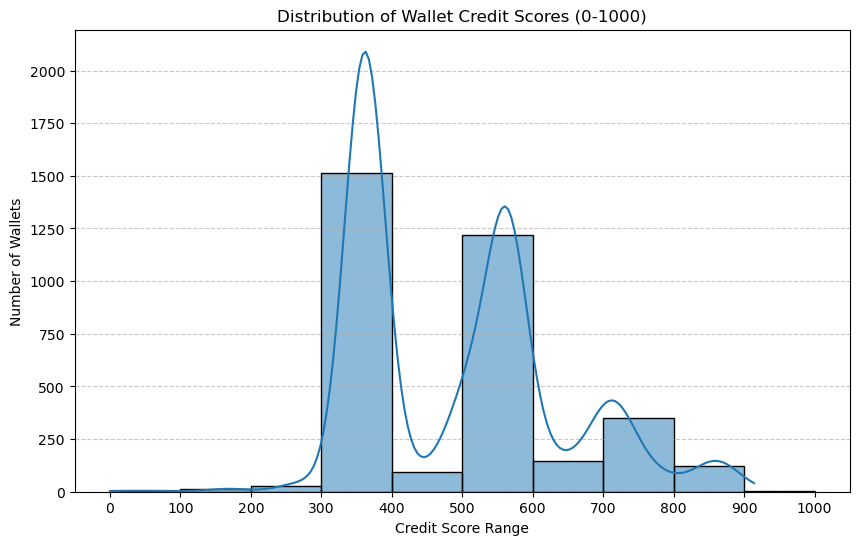


Characteristics of Low Score Wallets:
       num_liquidations  repayment_ratio  total_borrow_usd  total_deposit_usd
count         16.000000     1.600000e+01      1.600000e+01       1.600000e+01
mean           6.625000     1.243152e-01      3.733000e+20       2.947646e+22
std            6.631993     3.087025e-01      7.822354e+20       1.125668e+23
min            1.000000     0.000000e+00      7.602607e-02       0.000000e+00
25%            2.750000     0.000000e+00      2.810743e+02       1.216944e+03
50%            4.000000     2.784277e-19      5.397888e+03       1.788707e+04
75%            7.750000     1.245112e-17      1.128621e+20       7.787842e+20
max           26.000000     9.971383e-01      2.480924e+21       4.513961e+23

Characteristics of High Score Wallets:
       num_liquidations  repayment_ratio  total_borrow_usd  total_deposit_usd
count             128.0       128.000000      1.280000e+02       1.280000e+02
mean                0.0         0.913282      1.568600e+22     

In [10]:
# In your Jupyter Notebook (or save figures and generate analysis.md)

# Score Distribution Graph
plt.figure(figsize=(10, 6))
sns.histplot(wallet_features['credit_score'], bins=range(0, 1001, 100), kde=True, edgecolor='black')
plt.title('Distribution of Wallet Credit Scores (0-1000)')
plt.xlabel('Credit Score Range')
plt.ylabel('Number of Wallets')
plt.xticks(range(0, 1001, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Behavior of wallets in lower range (e.g., score < 200)
low_score_wallets = wallet_features[wallet_features['credit_score'] < 200]
print("\nCharacteristics of Low Score Wallets:")
print(low_score_wallets[['userWallet', 'num_liquidations', 'repayment_ratio', 'total_borrow_usd', 'total_deposit_usd']].describe())

# Behavior of wallets in higher range (e.g., score > 800)
high_score_wallets = wallet_features[wallet_features['credit_score'] > 800]
print("\nCharacteristics of High Score Wallets:")
print(high_score_wallets[['userWallet', 'num_liquidations', 'repayment_ratio', 'total_borrow_usd', 'total_deposit_usd']].describe())